<a href="https://colab.research.google.com/github/Utsav1123/machine_learning/blob/main/sentimen_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics as sk_met
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import pickle
import tkinter as tk
from tkinter import filedialog
import cv2 as cv
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('twitter_training.csv')
df2 = pd.read_csv('twitter_validation.csv')
print(df.columns)
print(df2.columns)
df=df.rename(columns={'Positive':'label','im getting on borderlands and i will murder you all ,':'text'})
df2=df2.rename(columns={'Irrelevant':'label','I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣':'text'})
print(df.columns)
print(df2.columns)
trainlab=df['label'].values
vallab=df2['label'].values
traintext=df['text'].values
valtext=df2['text'].values

traintext=traintext.astype(str)
valtext=valtext.astype(str)

totaltext=np.concatenate((traintext,valtext))

tokenizer_input = Tokenizer()
tokenizer_input.fit_on_texts(totaltext)
input_sequences = tokenizer_input.texts_to_sequences(totaltext)

max_sequence_length = 50
input_vocab_size = len(tokenizer_input.word_index) + 1

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')

totallab=np.concatenate((trainlab,vallab))
totallab=totallab.reshape(totallab.shape[0],1)

enc = OneHotEncoder()
enc_lab = enc.fit_transform(totallab).toarray()

x_train, x_test, y_train, y_test = train_test_split(input_sequences, enc_lab, test_size=0.2, random_state=42)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)




Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')
Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')
Index(['2401', 'Borderlands', 'label', 'text'], dtype='object')
Index(['3364', 'Facebook', 'label', 'text'], dtype='object')
(60544, 50) (15136, 50) (60544, 4) (15136, 4)


In [2]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [5]:
def translate_lstm(max_sequence_length,inputvo_cab_size,input_shape):
    input= tf.keras.Input(shape=input_shape[1:])
    e1= tf.keras.layers.Embedding(input_dim=input_vocab_size,output_dim=300,mask_zero=True)(input)
    lstm1= tf.keras.layers.LSTM(units=100,return_sequences=True)(e1)
    dropout1= tf.keras.layers.Dropout(0.2)(lstm1)
    lstm2=tf.keras.layers.LSTM(units=100)(dropout1)
    relu= tf.keras.layers.Dense(50, activation='relu')(lstm2)
    dropout= tf.keras.layers.Dropout(0.2)(relu)
    softmaxout= tf.keras.layers.Dense(4, activation='softmax')(dropout)
    model=tf.keras.Model(input,softmaxout)
    return model

model_lstm=translate_lstm(max_sequence_length,input_vocab_size,x_train.shape)
model_lstm.compile(optimizer='Adam',metrics=['accuracy'],loss='categorical_crossentropy')
model_lstm.summary()
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
history_lstm=model_lstm.fit(x=x_train,y=y_train,epochs=15,validation_data=(x_test,y_test), batch_size=8192)
model_lstm.save('sentiment_analysis_lstm.keras')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 300)           10338600  
                                                                 
 lstm (LSTM)                 (None, 50, 100)           160400    
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0   

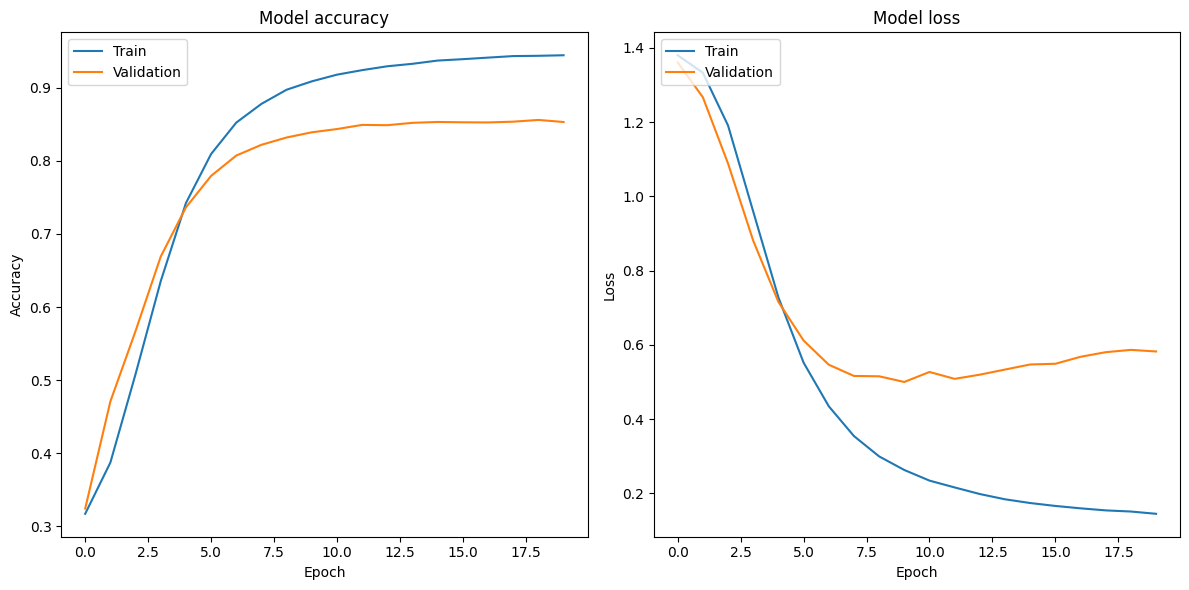

In [6]:
plot_training_history(history_lstm)

In [3]:
def translate_gru(max_sequence_length,input_vocab_size,input_shape):
    input= tf.keras.Input(shape=input_shape[1:])
    e1= tf.keras.layers.Embedding(input_dim=input_vocab_size,output_dim=300,mask_zero=True)(input)
    gru1= tf.keras.layers.GRU(units=100,return_sequences=True)(e1)
    dropout1= tf.keras.layers.Dropout(0.2)(gru1)
    gru2=tf.keras.layers.GRU(units=100)(dropout1)
    relu= tf.keras.layers.Dense(50, activation='relu')(gru2)
    dropout= tf.keras.layers.Dropout(0.2)(relu)
    softmaxout= tf.keras.layers.Dense(4, activation='softmax')(dropout)
    model=tf.keras.Model(input,softmaxout)
    return model

model_gru=translate_gru(max_sequence_length,input_vocab_size,x_train.shape)
model_gru.compile(optimizer='Adam',metrics=['accuracy'],loss='categorical_crossentropy')
model_gru.summary()
history_gru=model_gru.fit(x=x_train,y=y_train,epochs=15,validation_data=(x_test,y_test), batch_size=8192)
model_gru.save('sentiment_analysis_gru.keras')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           10338600  
                                                                 
 gru (GRU)                   (None, 50, 100)           120600    
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0     

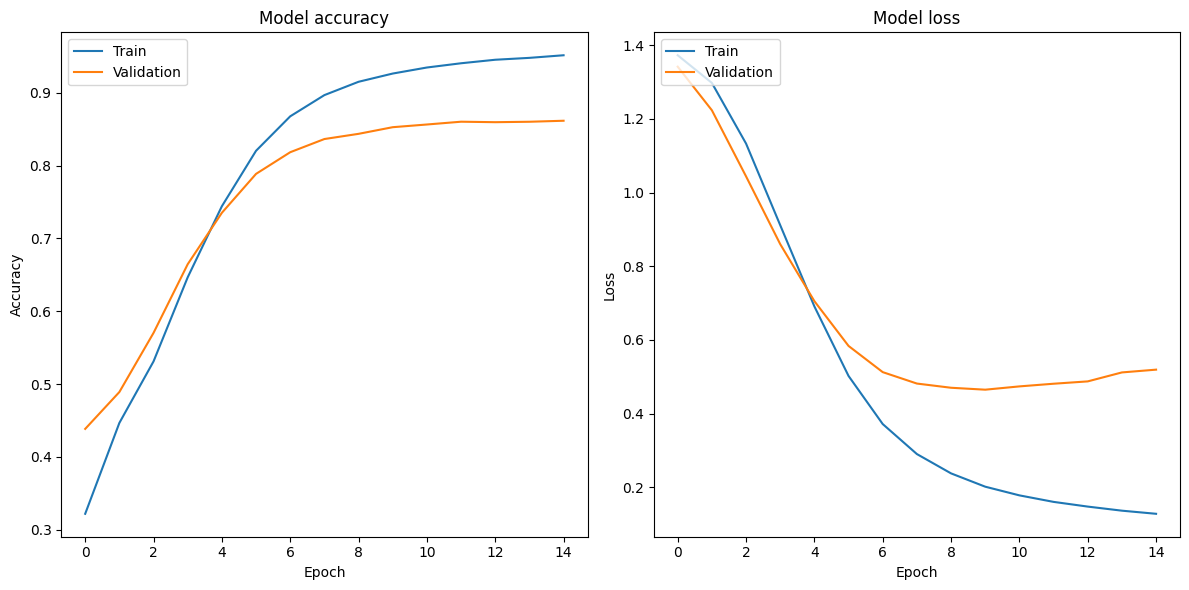

In [4]:
plot_training_history(history_gru)

In [3]:
def translate_rnn(max_sequence_length,input_vocab_size,input_shape):
    input= tf.keras.Input(shape=input_shape[1:])
    e1= tf.keras.layers.Embedding(input_dim=input_vocab_size,output_dim=300,mask_zero=True)(input)
    rnn1= tf.keras.layers.SimpleRNN(units=50,return_sequences=True)(e1)
    dropout1= tf.keras.layers.Dropout(0.2)(rnn1)
    rnn2=tf.keras.layers.SimpleRNN(units=50)(dropout1)
    relu= tf.keras.layers.Dense(50, activation='relu')(rnn2)
    dropout= tf.keras.layers.Dropout(0.2)(relu)
    softmaxout= tf.keras.layers.Dense(4, activation='softmax')(dropout)
    model=tf.keras.Model(input,softmaxout)
    return model

model_rnn=translate_rnn(max_sequence_length,input_vocab_size,x_train.shape)
model_rnn.compile(optimizer='Adam',metrics=['accuracy'],loss='categorical_crossentropy')
model_rnn.summary()
history_rnn=model_rnn.fit(x=x_train,y=y_train,epochs=15,validation_data=(x_test,y_test), batch_size=8192)
model_rnn.save('sentiment_analysis_rnn.keras')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           10338600  
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 50)            17550     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0     

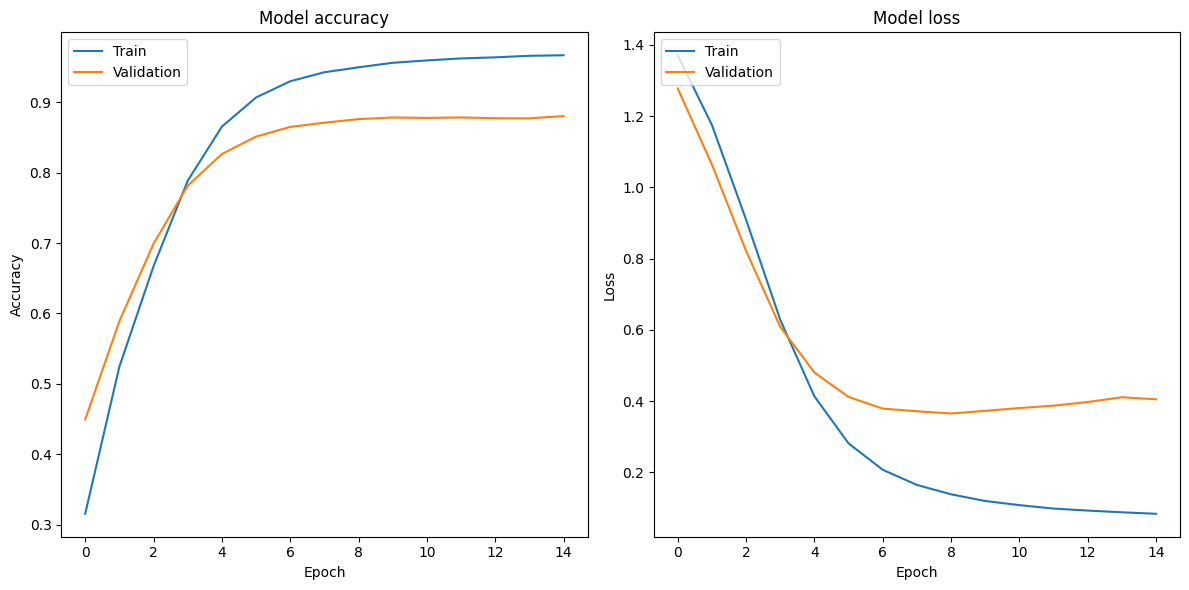

In [4]:
plot_training_history(history_rnn)